# Analysis and forecasting of Russian stock prices

We will analyze the prices of stock prices of the largest Russian companies (SBER, LKOH, GAZP, GMKN), and also try to predict prices using LSTM and [Hurst exponent](https://pdfs.semanticscholar.org/e796/95f7bf0d923ada8be5cbe986ef225147e1fa.pdf)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
#%matplotlib widget

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

from datetime import datetime

In [2]:
# The stocks we'll use for this analysis
comp_list = ['SBER.ME', 'LKOH.ME', 'GAZP.ME', 'GMKN.ME']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

#For loop for grabing yahoo finance data and setting as a dataframe
for stock in comp_list:   
    # Set DataFrame as the Stock Ticker
    globals()[stock[:4]] = DataReader(stock, 'yahoo', start, end)

## Common Analysis


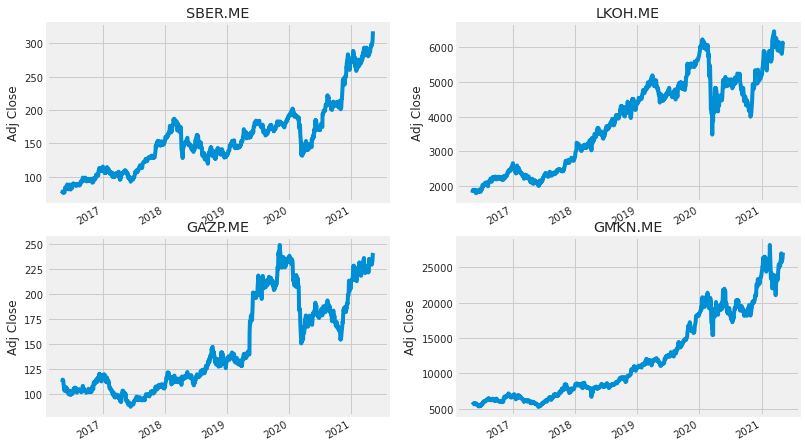

In [3]:
stock_df=[SBER, LKOH, GAZP, GMKN]

plt.figure(figsize=(12, 8))

for i, company in enumerate(stock_df, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(comp_list[i-1])

### Distribution of daily returns 

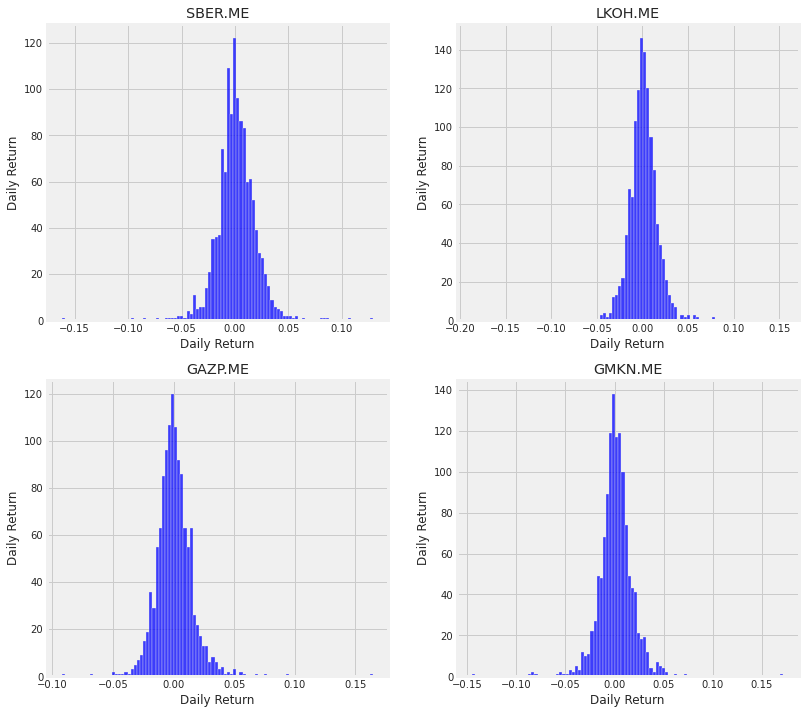

In [4]:
plt.figure(figsize=(12, 12))

for i, company in enumerate(stock_df, 1):
    company['Daily Return'] = company['Adj Close'].pct_change()
    plt.subplot(2, 2, i)
    sns.histplot(company['Daily Return'].dropna(), bins=100, color='blue')
    plt.ylabel('Daily Return')
    plt.title(comp_list[i-1])
    
plt.show()

### Volatility over the last 1000 observations

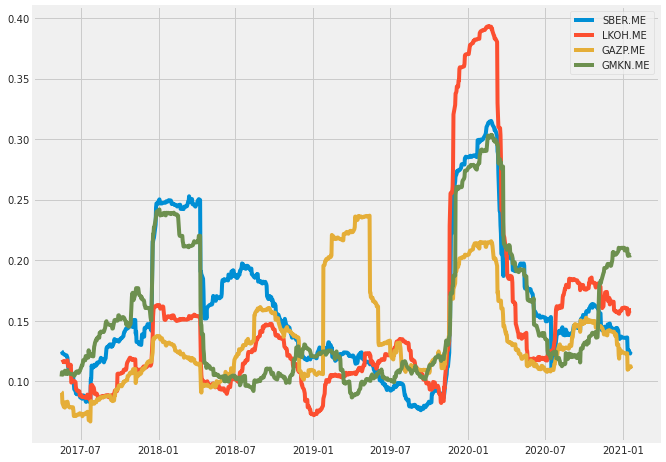

In [6]:
# Define the minumum of periods to consider 
min_periods = 75

plt.figure(figsize=(10, 8))

for i, company in enumerate(stock_df, 1):
    #plt.subplot(2, 2, i)
    vol=company['Daily Return'][:-1000:-1].dropna().rolling(min_periods).std() * np.sqrt(min_periods)
    plt.plot(vol, label=comp_list[i-1])
    plt.legend(loc='best')

plt.legend(loc='best')
    
plt.show()

### Feature calculation (momentum_score, hurst_f, RSI )

In [7]:
# Sort by date (ascending) for the momentum calculation
GAZP = GAZP.sort_values(by='Date')

# Get the latest date for the data we have
current_data_date = GAZP.index.max()

In [10]:
from scipy import stats

momentum_window = 125
minimum_momentum = 40

# Momentum score function
def momentum_score(ts):
    x = np.arange(len(ts))
    log_ts = np.log(ts)
    regress = stats.linregress(x, log_ts)
    annualized_slope = (np.power(np.exp(regress[0]), 252) -1) * 100
    return annualized_slope * (regress[2] ** 2)

# Here's an example implementation of the hurst exponent
def hurst_f(input_ts, lags_to_test=20):  
    # interpretation of return value
    # hurst < 0.5 - input_ts is mean reverting
    # hurst = 0.5 - input_ts is effectively random/geometric brownian motion
    # hurst > 0.5 - input_ts is trending
    tau = []
    lagvec = []  
    #  Step through the different lags  
    for lag in range(2, lags_to_test):  
        #  produce price difference with lag  
        pp = np.subtract(input_ts[lag:], input_ts[:-lag])  
        #  Write the different lags into a vector  
        lagvec.append(lag)  
        #  Calculate the variance of the differnce vector  
        tau.append(np.sqrt(np.std(pp)))  
    #  linear fit to double-log graph (gives power)  
    m = np.polyfit(np.log10(lagvec), np.log10(tau), 1)  
    # calculate hurst  
    hurst = m[0]*2

    return hurst 

In [11]:
GAZP['momentum'] = GAZP.Close.rolling(
    momentum_window,
    min_periods=minimum_momentum).apply(momentum_score,raw=True)

GAZP['hurst16'] = GAZP.Close.rolling(
    momentum_window,
    min_periods=minimum_momentum).apply(hurst_f,raw=True,args=(16,))

GAZP['hurst32'] = GAZP.Close.rolling(
    momentum_window,
    min_periods=minimum_momentum).apply(hurst_f,raw=True,args=(32,))

In [12]:
def rsi_fun(price, n=14):
    delta = price['Close'].diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(n).mean()
    RolDown = dDown.rolling(n).mean().abs()

    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    return rsi

GAZP['rsi'] = rsi_fun(GAZP)

In [13]:
GAZP.dropna(inplace=True)

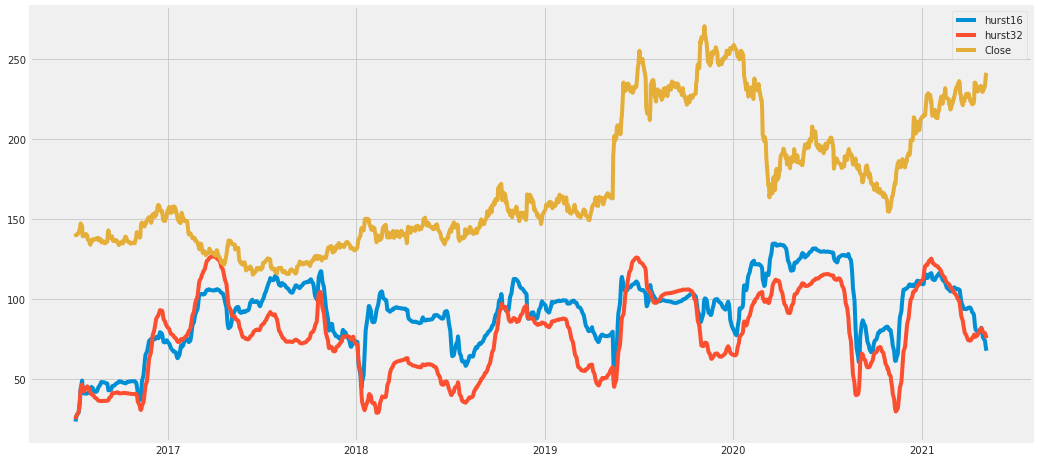

In [14]:
plt.figure(figsize=(16,8))

plt.plot(GAZP[[ 'hurst16']]*200, '-', label="hurst16")
plt.plot(GAZP[[ 'hurst32']]*200, '-', label="hurst32")
plt.plot(GAZP[[ 'Close']], '-', label="Close")

plt.legend(loc='best')
plt.show()


In [15]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=GAZP.index)
signals['signal'] = 0.0

# Create hurst16 over the short window
signals['hurst16'] = GAZP['hurst16']

# Create hurst32 over the long window
signals['hurst32'] = GAZP['hurst32']

# Create signals
signals['signal'] = np.where(signals['hurst16'] > signals['hurst32'], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

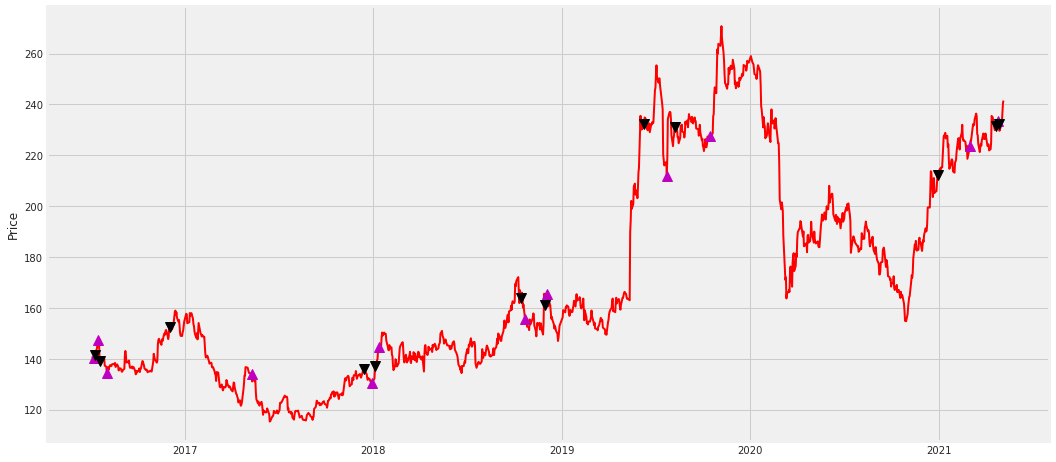

In [16]:
# Initialize the plot figure
fig=plt.figure(figsize=(16,8))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price')

# Plot the closing price
ax1.plot(GAZP['Close'],'-', markersize=10, color='r',lw=2.)

# Plot the buy signals
ax1.plot(GAZP.loc[signals.positions == 1.0].index, 
         GAZP.Close[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(GAZP.loc[signals.positions == -1.0].index, 
         GAZP.Close[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

### Simple backtesting of hurst startegy

In [122]:
def simple_backtest(init_capital, signals, stock_prices):
    # Set the initial capital
    initial_capital= float(init_capital)
    
    #Start whith only initial capital
    signals.iloc[0,0] = 0

    # Create a DataFrame `positions`
    positions = pd.DataFrame(index=signals.index).fillna(0.0)

    # Buy a 100 shares
    positions['Ticker'] = 100*signals['signal']   

    # Initialize the portfolio with value owned   
    portfolio = positions.multiply(stock_prices['Close'], axis=0)

    # Store the difference in shares owned 
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(stock_prices['Close'], axis=0)).sum(axis=1)

    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(stock_prices['Close'], axis=0)).sum(axis=1).cumsum()   

    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']

    # Add `returns` to portfolio
    portfolio['returns'] = portfolio['total'].pct_change()
    
    return portfolio

portfolio = simple_backtest(10000, signals, GAZP)


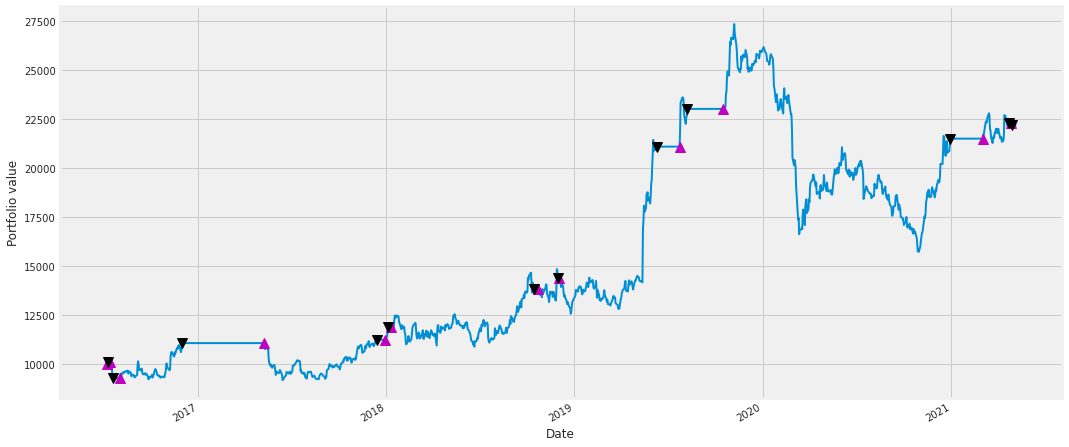

In [123]:
def show_portfolio(portfolio,signals):
    fig=plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(111, ylabel='Portfolio value')

    # Plot the equity curve in dollars
    portfolio['total'].plot(ax=ax1, lw=2.)

    # Plot the "buy" trades against the equity curve
    ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
             portfolio.total[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the "sell" trades against the equity curve
    ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
             portfolio.total[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Show the plot
    plt.show()
    
show_portfolio(portfolio, signals)

####  buy and hold strategy:

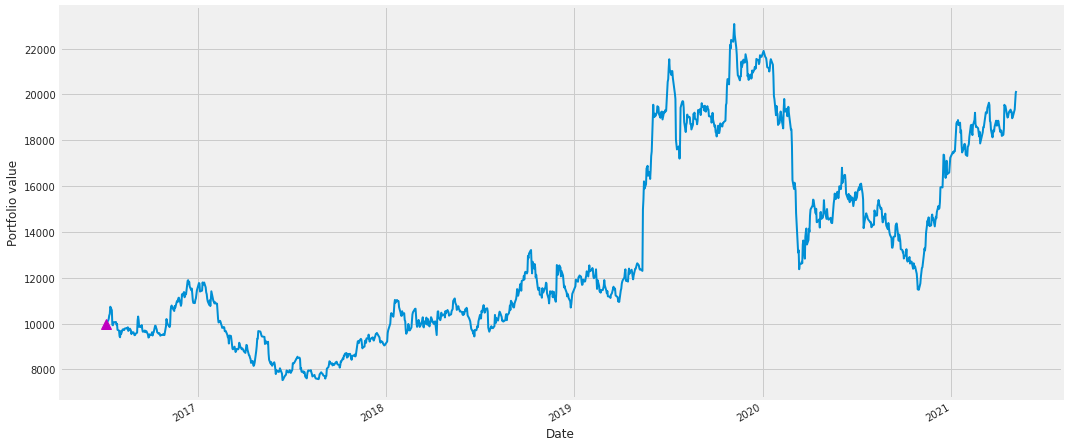

In [124]:
signals_buy_and_hold=signals.copy()
signals_buy_and_hold.loc[:,'signal'] = 1
signals_buy_and_hold.loc[:,'positions'] = 0
signals_buy_and_hold.iloc[1,3] = 1

portfolio_buy_and_hold = simple_backtest(10000, signals_buy_and_hold, GAZP)
show_portfolio(portfolio_buy_and_hold, signals_buy_and_hold)

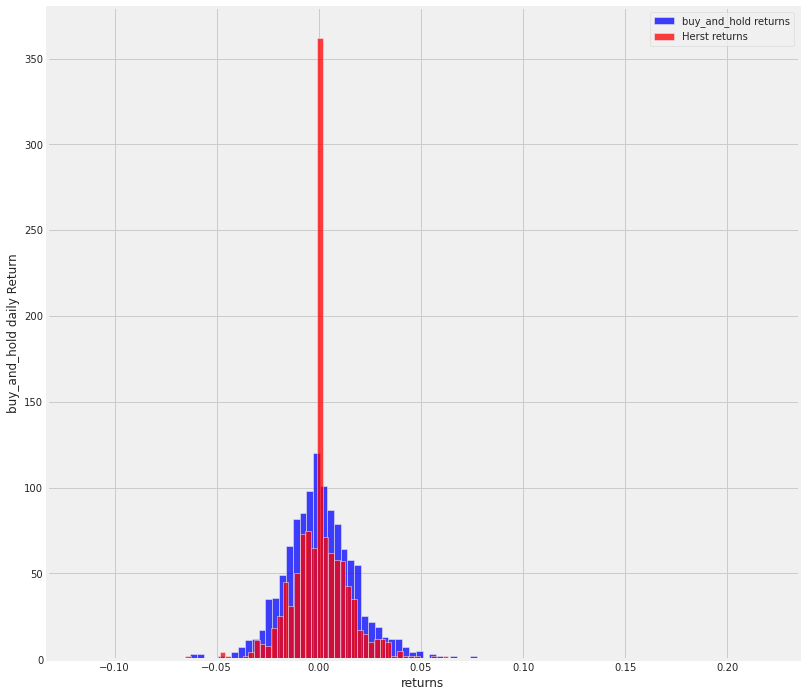

In [126]:
plt.figure(figsize=(12, 12))
sns.histplot(portfolio_buy_and_hold['returns'].dropna(), bins=100, color='blue',label="buy_and_hold returns")
sns.histplot(portfolio['returns'].dropna(), bins=100, color='red', label="Herst returns")
plt.legend(loc='best')
plt.ylabel('buy_and_hold daily Return')
    
plt.show()

In [127]:
from scipy.stats import ttest_ind

stat, pval = ttest_ind(portfolio_buy_and_hold['returns'].dropna(),
                       portfolio['returns'].dropna())
stat, pval

(0.00637431558345529, 0.9949145892533233)

Total value of Hurst portfolio > Total value of buy_and_hold portfolio, but hypothesis that the returns samples are from populations with equal means is not rejected



### Predicting LSTM

In [129]:
#Create a new dataframe with 'Close','rsi','hurst16' column
data = GAZP.filter(['Close','rsi','hurst16'])  
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))


In [130]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [131]:
scaler_for_close_price = MinMaxScaler(feature_range=(0,1))
scaler_for_close_price.fit(GAZP.filter(['Close']).values)

MinMaxScaler()

In [132]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)


In [133]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], data.shape[1])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
92/92 [==============================] - 13s 84ms/step - loss: 0.0253
Epoch 2/10
92/92 [==============================] - 7s 81ms/step - loss: 0.0024
Epoch 3/10
92/92 [==============================] - 7s 79ms/step - loss: 0.0021
Epoch 4/10
92/92 [==============================] - 7s 79ms/step - loss: 0.0017
Epoch 5/10
92/92 [==============================] - 7s 77ms/step - loss: 0.0017
Epoch 6/10
92/92 [==============================] - 7s 79ms/step - loss: 0.0013
Epoch 7/10
92/92 [==============================] - 7s 80ms/step - loss: 0.0017
Epoch 8/10
92/92 [==============================] - 7s 81ms/step - loss: 8.9497e-04
Epoch 9/10
92/92 [==============================] - 7s 80ms/step - loss: 9.1478e-04
Epoch 10/10
92/92 [==============================] - 7s 78ms/step - loss: 8.2192e-04


In [134]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, 0]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], data.shape[1]))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler_for_close_price.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions.reshape(1,-1) - y_test) ** 2)))
rmse


4.264325549244776

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


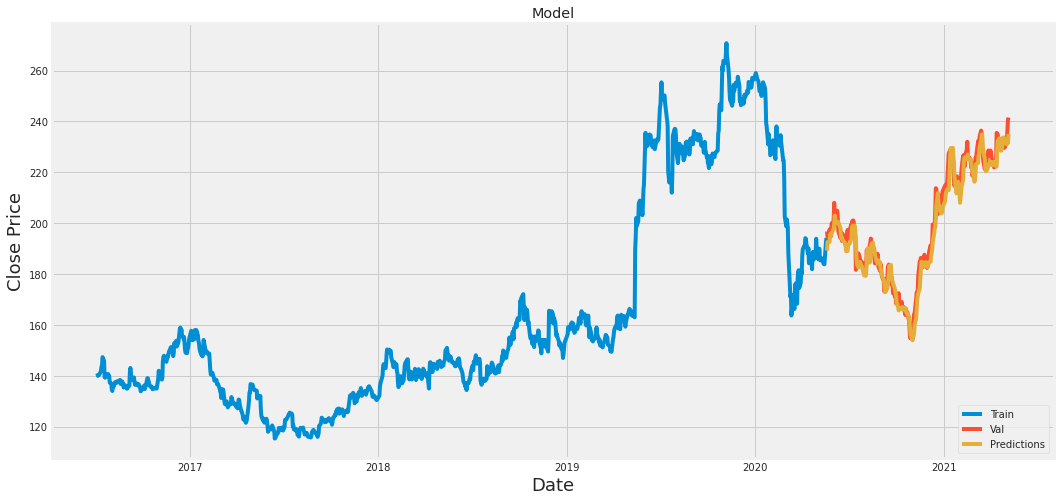

In [135]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid.loc[:,'Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()